<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></span><ul class="toc-item"><li><span><a href="#compare-dimensionality" data-toc-modified-id="compare-dimensionality-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>compare dimensionality</a></span></li><li><span><a href="#Find-single-gene-iModulons" data-toc-modified-id="Find-single-gene-iModulons-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Find single-gene iModulons</a></span></li><li><span><a href="#optimal-dimensionality" data-toc-modified-id="optimal-dimensionality-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>optimal dimensionality</a></span></li></ul></li></ul></div>

In [3]:
from pymodulon.core import IcaData
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from tqdm.notebook import tqdm

In [10]:
# Directory containing ICA outputs
DATA_DIR_332 = './data/ICA_332/'

# Load data

In [11]:
def load_M(dim):
    return pd.read_csv(os.path.join(DATA_DIR_332,str(dim),'S.csv'),index_col=0)

def load_A(dim):
    return pd.read_csv(os.path.join(DATA_DIR_332,str(dim),'A.csv'),index_col=0)


In [12]:
dim_list = os.listdir(DATA_DIR_332)
if '.DS_Store' in dim_list:
    dim_list.remove('.DS_Store')

dims = sorted([int(x) for x in dim_list])
M_data = [load_M(dim) for dim in dims]
A_data = [load_A(dim) for dim in dims]

n_components = [m.shape[1] for m in M_data]

## compare dimensionality

In [13]:
final_m = M_data[-1]
thresh = 0.7

n_final_mods = []
for m in tqdm(M_data):
    corrs = pd.DataFrame(index=final_m.columns,columns=m.columns)
    for col1 in final_m.columns:
        for col2 in m.columns:
            corrs.loc[col1,col2] = abs(stats.pearsonr(final_m[col1],m[col2])[0])
    n_final_mods.append(len(np.where(corrs > thresh)[0]))

  0%|          | 0/17 [00:00<?, ?it/s]

## Find single-gene iModulons 

In [14]:
n_single_genes = []
for m in tqdm(M_data):
    counter = 0
    for col in m.columns:
        sorted_genes = abs(m[col]).sort_values(ascending=False)
        if sorted_genes.iloc[0] > 2 * sorted_genes.iloc[1]:
            counter += 1
    n_single_genes.append(counter)

  0%|          | 0/17 [00:00<?, ?it/s]

## optimal dimensionality

In [15]:
non_single_components = np.array(n_components) - np.array(n_single_genes)

DF_stats = pd.DataFrame([n_components,n_final_mods,non_single_components,n_single_genes],
                        index=['Robust Components','Final Components','Multi-gene Components',
                        'Single Gene Components'],
                        columns=dims).T
DF_stats.sort_index(inplace=True)

dimensionality = DF_stats[DF_stats['Final Components'] >= DF_stats['Multi-gene Components']].iloc[0].name
print('Optimal Dimensionality:',dimensionality)

Optimal Dimensionality: 130


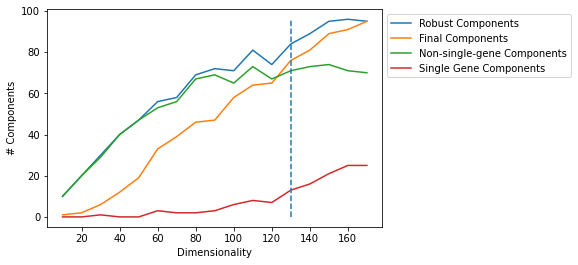

In [17]:
plt.plot(dims,n_components,label='Robust Components')
plt.plot(dims,n_final_mods,label='Final Components')
plt.plot(dims,non_single_components,label='Non-single-gene Components')
plt.plot(dims,n_single_genes,label='Single Gene Components')

plt.vlines(dimensionality,0,max(n_components),linestyle='dashed')

plt.xlabel('Dimensionality')
plt.ylabel('# Components')
plt.legend(bbox_to_anchor=(1,1))